In [1]:
import random
import time

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np

import pathlib
import logging

import torch
import torch.distributed as dist
import torch.utils.data.distributed
import torch.backends.cudnn as cudnn

import os

In [2]:
from distoptim import fedavg
import models
import util_v4_text as util 

In [3]:
class Args_parser():
    def __init__(self, seltype = "rand", powd = 30, num_users = 30, epochs = 50000):
        self.name = "default"
        self.backend = "Gloo" # "nccl" for GPU, "Gloo" for CPU
        self.model = "MLP"
        self.num_classes = 10 # number of classes
        self.gmf = 0 # global (server) momentum factor
        self.num_users = num_users # 30
        self.frac = 0.1
        self.powd = powd # 6, number of selected subset workers per round
        self.alpha = 0.2 # control the non-iidness of dataset
        self.seed = 1 # random seed
        self.bs = 64 # batch size on each worker/client
        self.lr = 0.1 # 0.00002 # client learning rate
        self.momentum = 0.0 # ocal (client) momentum factor
        self.rounds = 500 # total communication rounds
        self.decay = 1 # 1: decay LR, 0: no decay
        self.print_freq = 100 # print info frequency
        self.size = 3 # number of local workers
        self.fracC = 0.03 # fraction of selected workers per round
        self.ensize = 100 # number of all workers
        self.rank = 0 # the rank of worker
        self.rnd_ratio = 0.1 # hyperparameter for afl
        self.delete_ratio = 0.75 # hyperparameter for afl
        self.save = "store_true" # whether save the training results
        self.p = "store_true" # whether the dataset is partitioned or not
        self.NIID = "store_true" # whether the dataset is non-iid or not
        self.commE = "store_true" # activation of $cpow-d$
        self.constantE = "store_true" # whether all the local workers have an identical number of local epochs or not
        self.optimizer  ="local" # optimizer name
        self.initmethod = "tcp://" # init method
        self.mu = 0 # mu parameter in fedprox
        self.dataset = "fmnist" # type of dataset
        
        self.localE = 30 # number of local epochs
        self.epochs = epochs # 15000
        self.seltype = seltype # "rand"
        self.dim = 5
        self.eq = 0

In [4]:
class MLP_text(nn.Module):
    def __init__(self, input_size, dim_hidden1, dim_hidden2, dim_hidden3, dim_out):
        super(MLP_text, self).__init__()
        self.layer_input = nn.Linear(input_size, dim_hidden1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden1 = nn.Linear(dim_hidden1, dim_hidden2)
        self.layer_hidden2 = nn.Linear(dim_hidden2, dim_hidden3)
        self.layer_hidden3 = nn.Linear(dim_hidden3, dim_out)
        self.logsoftmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.layer_input(x)
        x = self.relu(x)
        x = self.layer_hidden1(x)
        x = self.relu(x)
        x = self.layer_hidden2(x)
        x = self.relu(x)
        x = self.layer_hidden3(x)

        return self.logsoftmax(x)
    
Sent_model = MLP_text(input_size=200, dim_hidden1=128, dim_hidden2 = 86, dim_hidden3 = 30, dim_out=2)


Sent_model.get_parameter

def model_info(model):
    
    print(Sent_model.get_parameter)
    
    num_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, "\n", param.data)
            num_params += param.data.flatten().size()[0]

    print("Total number of parameters", num_params)
    
model_info(Sent_model)

<bound method Module.get_parameter of MLP_text(
  (layer_input): Linear(in_features=200, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden1): Linear(in_features=128, out_features=86, bias=True)
  (layer_hidden2): Linear(in_features=86, out_features=30, bias=True)
  (layer_hidden3): Linear(in_features=30, out_features=2, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)>
layer_input.weight 
 tensor([[-0.0481, -0.0290,  0.0317,  ..., -0.0486, -0.0539, -0.0147],
        [-0.0403, -0.0430, -0.0391,  ...,  0.0311, -0.0173,  0.0686],
        [-0.0043, -0.0061,  0.0633,  ..., -0.0603, -0.0112, -0.0675],
        ...,
        [-0.0331,  0.0185,  0.0659,  ...,  0.0417, -0.0550, -0.0026],
        [ 0.0133, -0.0670, -0.0278,  ...,  0.0598, -0.0401,  0.0056],
        [ 0.0671, -0.0255, -0.0134,  ...,  0.0013, -0.0040, -0.0328]])
layer_input.bias 
 tensor([-0.0001, -0.0090,  0.0419,  0.0255,  0.0440, -0.0594,  0.0555,  0.0097,
        -0.0703, -0.0

In [34]:
# Sent_model
A = torch.randn(8, 200)
output = Sent_model(A)

In [50]:
target = torch.Tensor([0, 1, 0, 1, 0, 1, 0, 0])
target

num_class = 2

vector = torch.zeros((target.size()[0]), num_class)

for i in range(len(target)):
    vector[i, int(target[i])] = 1.0

vector

vector.type(torch.LongTensor)

vector2 = vector.copy()

AttributeError: 'Tensor' object has no attribute 'copy'

In [41]:
criterion = nn.NLLLoss().to(device)

In [45]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])

output = loss(m(input), target)
# output.backward()
m(input), target

# # 2D loss example (used, for example, with image inputs)
# N, C = 5, 4
# loss = nn.NLLLoss()
# # input is of size N x C x height x width
# data = torch.randn(N, 16, 10, 10)
# conv = nn.Conv2d(16, C, (3, 3))
# m = nn.LogSoftmax(dim=1)
# # each element in target has to have 0 <= value < C
# target = torch.empty(N, 8, 8, dtype=torch.long).random_(0, C)
# output = loss(m(conv(data)), target)
# output.backward()

(tensor([[-1.8893, -2.5866, -1.2095, -1.0620, -2.0446],
         [-3.2653, -1.9882, -1.5745, -1.3263, -1.0432],
         [-1.3411, -2.3245, -2.7554, -2.2392, -0.7540]],
        grad_fn=<LogSoftmaxBackward0>),
 tensor([1, 0, 4]))

In [42]:
criterion(vector, output)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [5]:

cols = ["polarity", "id", "data", "query", "user", "text"]
traindata = pd.read_csv('Sent140/traindata_sent140.csv', names=cols, encoding='latin-1')
testdata = pd.read_csv('Sent140/testdata_sent140.csv', names=cols, encoding='latin-1')  

The data is a CSV with emoticons removed. Data file format has 6 fields:  
0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)  
1 - the id of the tweet (2087)  
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)  
3 - the query (lyx). If there is no query, then this value is NO_QUERY.  
4 - the user that tweeted (robotickilldozr)  
5 - the text of the tweet (Lyx is cool)  

In [6]:
traindata.head(5)

,polarity,id,data,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<Axes: >

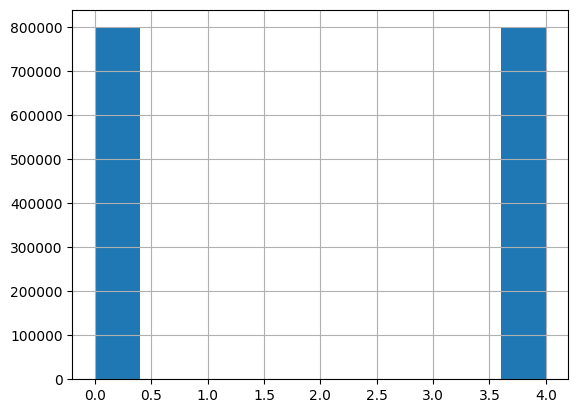

In [7]:
traindata["polarity"].hist()

<Axes: >

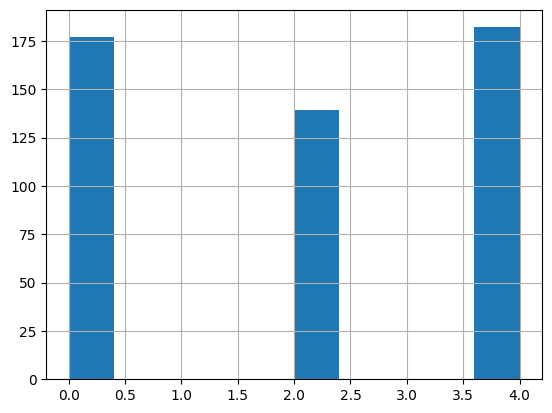

In [8]:
testdata["polarity"].hist()

In [9]:
logging.basicConfig(format='%(levelname)s - %(message)s', level=logging.INFO)
logging.debug('This message should appear on the console')

args = Args_parser()

In [10]:
torch.cuda.manual_seed(1)

In [11]:
def run(rank, size):
    print(rank, size)
    
    # initiate experiments folder
    save_path = '/users/name/'
    fold = 'lr{:.4f}_bs{}_cp{}_a{:.2f}_e{}_r0_n{}_f{:.2f}/'.format(args.lr, args.bs, args.localE, args.alpha, args.seed,
                                                                   args.ensize, args.fracC)
    if args.commE:
        fold = 'com_'+fold
    folder_name = save_path+args.name+'/'+fold
    file_name = '{}_rr{:.2f}_dr{:.2f}_lr{:.3f}_bs{:d}_cp{:d}_a{:.2f}_e{}_r{}_n{}_f{:.2f}_p{}.csv'.format(args.seltype,
                                                     args.rnd_ratio, args.delete_ratio, args.lr, args.bs, args.localE,
                                                    args.alpha, args.seed, rank, args.ensize, args.fracC, args.powd)
    pathlib.Path(folder_name).mkdir(parents=True, exist_ok=True)

    # initiate log files
    saveFileName = folder_name + file_name
    args.out_fname = saveFileName
    with open(args.out_fname, 'w+') as f:
        print('BEGIN-TRAINING\n' 'World-Size,{ws}\n' 'Batch-Size,{bs}\n' 'Epoch,itr,'
            'loss,trainloss,avg:Loss,Prec@1,avg:Prec@1,val,trainval,updtime,comptime,seltime,entime'.format(
            ws=args.size, bs=args.bs), file=f)

    # seed for reproducibility
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True

    # load data
    partition, train_loader, test_loader, dataratios, traindata = util.partition_dataset(size, args, 0)

    # initialization for client selection
    cli_loss, cli_freq, cli_val = np.zeros(args.ensize)+1, np.zeros(args.ensize), np.zeros(args.ensize)

    tmp_cli = [torch.tensor(0, dtype=torch.float32).cuda() for _ in range(dist.get_world_size())]
    tmp_clifreq = [torch.tensor(0).cuda() for _ in range(dist.get_world_size())]

    dist.barrier()
    # select client for each round, in total m ranks
    send = torch.zeros(args.size, dtype=torch.int32).cuda()
    if rank == 0:
        replace_param = False
        if args.seltype =='rand':
            replace_param = True

        idxs_users = np.random.choice(args.ensize, size=args.size, replace=replace_param)
        send = [torch.tensor(int(ii)).cuda() for ii in idxs_users]
    dist.barrier()

    for i in range(args.size):
        dist.broadcast(tensor=send[i], src=0)
    dist.barrier()
    sel_idx = int(send[rank])

    # define neural nets model, criterion, and optimizer
    model = models.MLP_text(input_size=200, dim_hidden1=128, dim_hidden2 = 86, dim_hidden3 = 30, dim_out=args.num_classes).cuda()
    criterion = nn.NLLLoss().cuda()

    # select optimizer according to algorithm
    algorithms = {'fedavg': fedavg}

    selected_opt = algorithms[args.optimizer]
    optimizer = selected_opt(model.parameters(),
                      lr=args.lr,
                      gmf=args.gmf, # set to 0
                      mu = args.mu, # set to 0
                      ratio=dataratios[rank],
                      momentum=args.momentum, # set to 0
                      nesterov = False,
                      weight_decay=1e-4)


    for rnd in range(args.rounds):

        # Initialize hyperparameters
        local_epochs = args.localE
        weight = 1/args.size

        # Clients locally train for several local epochs
        loss_final = 0
        dist.barrier()
        comm_update_start = time.time()
        for t in range(local_epochs):
            singlebatch_loader = util.partitiondata_loader(partition, sel_idx, args.bs, traindata)
            loss = train_text(model, criterion, optimizer, singlebatch_loader, t)
            loss_final += loss/local_epochs
        dist.barrier()
        comm_update_end = time.time()
        update_time = comm_update_end - comm_update_start

        # Getting value function for client selection (required only for 'rpow-d', 'afl')
        dist.barrier()      # TODO: implement multi-arm bandit
        dist.all_gather(tmp_cli, torch.tensor(loss_final).cuda())
        dist.all_gather(tmp_clifreq, torch.tensor(int(sel_idx)).cuda())
        dist.barrier()
        for i, i_val in enumerate(tmp_clifreq):
            cli_freq[i_val.item()]+= 1         # Cli freq is the entire clients that are selected for all rounds
            cli_val[i_val.item()] = tmp_cli[i].item()
        not_visited = np.where(cli_freq == 0)[0]

        for ii in not_visited:
            if args.seltype == 'afl':
                cli_val[ii] = -np.inf
            else:
                cli_val[ii] = np.inf

        # synchronize parameters
        dist.barrier()
        optimizer.average(weight=weight)
        dist.barrier()

        # evaluate test accuracy
        test_acc, test_loss = evaluate(model, test_loader, criterion)

        # evaluate loss values and sync selected frequency
        cli_loss, cli_comptime = evaluate_client(model, criterion, partition, traindata)
        train_loss = sum([cli_loss[i]*dataratios[i] for i in range(args.ensize)])
        train_loss1 = sum(cli_loss)/args.ensize

        dist.barrier()

        # Select client for each round, in total m ranks
        send = torch.zeros(args.size, dtype=torch.int32).cuda()
        comp_time, sel_time = 0, 0

        if rank == 0:
            sel_time_start = time.time()
            idxs_users, rnd_idx = util.sel_client(dataratios, cli_loss, cli_val, args, rnd)
            sel_time_end = time.time()
            sel_time = sel_time_end - sel_time_start

            if args.seltype == 'pow-d' or args.seltype == 'pow-dint':
                comp_time = max([cli_comptime[int(i)] for i in rnd_idx])

            send = [torch.tensor(int(ii)).cuda() for ii in idxs_users]
        dist.barrier()
        for i in range(args.size):
            dist.broadcast(tensor=send[i], src=0)
        dist.barrier()
        sel_idx = int(send[rank])

        # record metrics
        logging.info("Round {} rank {} test accuracy {:.3f} test loss {:.3f}".format(rnd, rank, test_acc, test_loss))
        with open(args.out_fname, '+a') as f:
            print('{ep},{itr},{loss:.4f},{trainloss:.4f},{filler},'
                  '{filler},{filler},'
                  '{val:.4f},{other:.4f},{updtime:.4f},{comptime:.4f},{seltime:.4f},{entime:.4f}'
                  .format(ep=rnd, itr=-1, loss=test_loss, trainloss=train_loss,
                          filler=-1, val=test_acc, other=train_loss1, updtime=update_time, comptime=comp_time,
                          seltime=sel_time, entime=update_time+comp_time+sel_time), file=f)


def evaluate_client(model, criterion, partition, traindata):

    '''
    Evaluating each client's local loss values for the current global model for client selection
    :param model: current global model
    :param criterion: loss function
    :param partition: dataset dict for clients
    :return: cli_loss = list of local loss values, cli_comptime = list of computation time
    '''

    cli_comptime, cli_loss = [], []
    model.eval()

    # Get data from client to evaluate local loss on
    for i in range(args.ensize):
        partitioned = partition[i]

        # cpow-d
        if args.commE:
            seldata_idx = random.sample(range(len(partitioned)), k=int(min(args.bs, len(partitioned))))
        else:
            seldata_idx = partitioned

        other = torch.utils.data.Subset(traindata, indices=seldata_idx)
        train_loader = torch.utils.data.DataLoader(other, batch_size=args.bs, shuffle=False,
                                                    pin_memory=True)

        # Compute local loss values or proxies for the clients
        tmp, total = 0,0
        with torch.no_grad():
            comptime_start = time.time()
            for batch_idx, (data, target) in enumerate(train_loader):
                data = data.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)
                vec_target = vector_encoding(args.num_classes, target)

                vec_target = vec_target.cuda(non_blocking=True)
                vec_target = torch.cuda.LongTensor(vec_target.type(torch.cuda.LongTensor))

                outputs = model(data)
                loss = criterion(outputs, vec_target)
                tmp += loss.item()
                total += 1

            final_loss = tmp/total
            comptime_end = time.time()
            cli_comptime.append(comptime_end-comptime_start)
            cli_loss.append(final_loss)

    return cli_loss, cli_comptime


def evaluate(model, test_loader, criterion):

    """
    Evaluate test accuracy
    """

    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    # Get test accuracy for the current model
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            data = data.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)
            vec_target = vector_encoding(args.num_classes, target)

            vec_target = vec_target.cuda(non_blocking=True)
            vec_target = torch.cuda.LongTensor(vec_target.type(torch.cuda.LongTensor))

            # Inference
            outputs = model(data)
            batch_loss = criterion(outputs, vec_target)
            loss += batch_loss.item()

            # Prediction
            _, pred_labels = torch.max(outputs,1)
            correct += torch.sum(torch.eq(pred_labels, vec_target)).item() / len(pred_labels)
            total += 1

        acc = (correct / total) * 100
        los = loss/total

    return acc, los


def train_text(model, criterion, optimizer, loader, epoch):
    """
    train model on the sampled mini-batch for $\tau$ epochs
    """

    model.train()
    loss, total, correct = 0.0, 0.0, 0.0

    for batch_idx, (data, target) in enumerate(loader):
        # data loading
        data = data.cuda(non_blocking = True)
        target = target.cuda(non_blocking = True)
        vec_target = vector_encoding(args.num_classes, target)

        vec_target = vec_target.cuda(non_blocking = True)
        vec_target = torch.cuda.LongTensor(vec_target.type(torch.cuda.LongTensor))
        output = model(data)
        batch_loss = criterion(output, vec_target)

        # backward pass
        batch_loss.backward()

        # gradient clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10, norm_type=2)

        # gradient step
        optimizer.step()
        optimizer.zero_grad()

        # write log files
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(output, 1)
        correct += torch.sum(torch.eq(pred_labels, vec_target)).item()/len(pred_labels)
        total += 1

        acc = (correct / total)*100
        los = loss / total

        if batch_idx % args.print_freq == 0 and args.save:
            logging.debug('epoch {} itr {}, '
                         'rank {}, loss value {:.4f}, train accuracy {:.3f}'
                         .format(epoch, batch_idx, rank, los, acc))

            with open(args.out_fname, '+a') as f:
                print('{ep},{itr},'
                      '{loss:.4f},-1,-1,'
                      '{top1:.3f},-1,-1,-1,-1,-1,-1'
                      .format(ep=epoch, itr=batch_idx,
                              loss=los, top1=acc), file=f)

    with open(args.out_fname, '+a') as f:
        print('{ep},{itr},'
              '{loss:.4f},-1,-1,'
              '{top1:.3f},-1,-1,-1,-1,-1,-1'
              .format(ep=epoch, itr=batch_idx,
                      loss=los, top1=acc), file=f)

    return los


def init_processes(rank, size, fn):
    """ Initialize the distributed environment. """
    os.environ['MASTER_ADDR'] = '127.0.0.1'
    os.environ['MASTER_PORT'] = '29500'
    dist.init_process_group(backend= args.backend, 
                            # init_method= "spawn://", #args.initmethod, 
                            rank=rank, 
                            world_size=size)
    fn(rank, size)


In [12]:
def run(rank, size):
    print(rank, size)
    
def init_processes(rank, size, fn):
    """ Initialize the distributed environment. """
    os.environ['MASTER_ADDR'] = '127.0.0.1'
    os.environ['MASTER_PORT'] = '29500'
    dist.init_process_group(backend= args.backend, 
                            # init_method= "spawn://", #args.initmethod, 
                            rank=rank, 
                            world_size=size)
#     fn(rank, size)

In [ ]:
rank = args.rank
size = args.size

# os.environ['MASTER_ADDR'] = "Localhost" # '127.0.0.1'
# os.environ['MASTER_PORT'] = '29500'

dist.init_process_group(backend= args.backend, 
                        init_method= "file:///root/workspace/Power-of-Choice/MLP_sentiment_analysis_Twitter/test/sharedfile", # "spawn://", #args.initmethod, 
                        rank=rank, 
                        world_size=size)

# init_processes(rank, size, run)

In [9]:
torch.distributed.is_available(), torch.distributed.is_initialized()

(True, False)

In [ ]:
"""run.py:"""
# !/usr/bin/env python
import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp

def run(rank, size):
    """ Distributed function to be implemented later. """
    pass

def init_process(rank, size, fn):
    """ Initialize the distributed environment. """
    os.environ['MASTER_ADDR'] = '127.0.0.1'
    os.environ['MASTER_PORT'] = '29500'
    dist.init_process_group(backend='gloo', rank=rank, world_size=size)
    fn(rank, size)



size = 2
processes = []
# mp.set_start_method("spawn")
for rank in range(size):
    p = mp.Process(target=init_process, args=(rank, size, run))
    p.start()
    processes.append(p)

for p in processes:
    p.join()
    
dist

# init_process(1, 2, run)

In [14]:
# import numpy as np

# arr = np.random.rand(10000, 10000)

# arr.itemsize*arr.size / 1e6

# arr @ arr